# Final assignment

## Instructions

- Read the instructions for the final assignment from the [course page](https://sustainability-gis.readthedocs.io/en/latest/lessons/final-assignment/final-assignment.html).
- To get help with Markdown formatting check [this page](https://www.markdownguide.org/cheat-sheet/).
- If you don't know how to add a Markdown cell check [this page](https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook)

## Add your work below

Mix markdown cells with code cells regularly to explain and document your work / codes (in a similar manner as how the Exercises of this course were written). 
Below we provide you a suggestion for the structure of the report by listing the main components that would be good to include in your work. However, you do not necessarily need to follow this structure and you can adjust the headings as you see best.

## 1. Introduction

"The global attention to transport has continued in recent years. World leaders recognized unanimously at the 2012 United Nations Conference on Sustainable Development (Rio +20) that transportation and mobility are central to sustainable development. Sustainable transportation can enhance economic growth and improve accessibility. Sustainable transport achieves better integration of the economy while respecting the environment. improving social equity, health, resilience of cities, urban-rural linkages and productivity of rural areas"

My two focus cities: Memphis, TN and Austin, TX
Comparing the cities on three indicators from SDG target 11.2:
- Road traffic deaths per 100,000 population
 Preliminary research:
 Memphis: 250 deaths in 2020 / 651,932 total population = 38 deaths per 100,000
 Austin: 74 deaths in 2018 / 935,755 total population = 7.9 deaths per 100,000
- Access to all-weather road (% access within [x] km distance to road)
- Percentage of people within 0.5km of public transit running at least every 20 minutes.

## 2. Data and methods

Describe your data (list also the used data sources) and give an overview of the methods that you use in your work.

Data sources for Crash Reports: 
data.austintexas.gov
TN Department of Safety & Homeland Security 
Data sources for Public Transit:
General Transit Feed Specification data (GTFS) fetched from transitland

In [1]:
# Import all necessary plugins
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
from pyproj import CRS
import rasterio
import os
import numpy as np
from rasterio.plot import show
from rasterio.features import shapes
#from cenpy import products
import matplotlib.pyplot as plt
from pyrosm import OSM, get_data
import osmnx as ox 
import networkx as nx

In [3]:
# Data processing, does not need to be run as the data has already been unzipped 
import zipfile
with zipfile.ZipFile("data/capmetro.zip","r") as zip_ref:
    zip_ref.extractall("data/Austin_TX_Transitland")

In [2]:
# Read in the data 
mem_df = pd.read_csv('data/Memphis_TN_transitfeed/stops.txt', delimiter = ",")
austin_df = pd.read_csv('data/Austin_TX_Transitland/stops.txt', delimiter = ",")

In [3]:
def points_geom(df):
    ''''''
    ## Create Points out of the lon and lat columns 
    ''''''
    # creating a geometry column 
    geometry = [Point(xy) for xy in zip((df.filter(regex='_lon$')).squeeze(), (df.filter(regex='_lat$',axis=1)).squeeze())]
    # Coordinate reference system : WGS84
    crs = CRS("WGS84")
    # Creating a Geographic data frame 
    df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    return df
    
stops_mem = points_geom(mem_df)
stops_austin = points_geom(austin_df)
stops_mem.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,geometry
0,6,YALCOVWM,YALE@COVINGTON PIKE,YALE RD & CONNECTING RD,35.221558,-89.897067,NaN,NaN,NaN,NaN,NaN,0,POINT (-89.89707 35.22156)
1,7,AIRKETSN,AIRWAYS BLVD@KETCHUM,AIRWAYS BLVD & KETCHUM RD,35.079543,-89.984917,NaN,NaN,NaN,NaN,NaN,0,POINT (-89.98492 35.07954)
2,10,CLEMA1SN,CLEVELAND@MADISON,N CLEVELAND ST & COURT AVE,35.139020,-90.016438,NaN,NaN,NaN,NaN,NaN,0,POINT (-90.01644 35.13902)
3,15,FOUGEOSF,4TH ST@ GEORGIA AVE,S 4TH ST & E GEORGIA AVE,35.128896,-90.050605,NaN,NaN,NaN,NaN,NaN,0,POINT (-90.05061 35.12890)
4,24,FROGEPNN,CENTRAL STATION,S FRONT ST & E CALHOUN AVE,35.132731,-90.060719,NaN,NaN,NaN,NaN,NaN,0,POINT (-90.06072 35.13273)


In [4]:
stops_austin.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,corner_placement,stop_position,on_street,at_street,heading,geometry
0,243,243,Rio Grande/15th,000606 15Th & Rio Grande,30.278966,-97.746339,NaN,https://www.capmetro.org/stopdetail/index.php?...,0,NaN,NaN,0.0,NW,F,15Th,Rio Grande,288.0,POINT (-97.74634 30.27897)
1,466,466,8740 Lamar/Payton Gin,008740 Lamar & Payton Gin,30.356809,-97.701066,NaN,https://www.capmetro.org/stopdetail/index.php?...,0,NaN,NaN,0.0,SW,M,Lamar,Payton Gin,227.0,POINT (-97.70107 30.35681)
2,467,467,Fairfield Station (SB),008630 Lamar & Fairfield,30.355296,-97.703128,NaN,https://www.capmetro.org/stopdetail/index.php?...,0,NaN,NaN,0.0,SW,F,Lamar,Fairfield,230.0,POINT (-97.70313 30.35530)
3,468,468,Lamar/Thurmond,008400 Lamar & Thurmond,30.353139,-97.706082,NaN,https://www.capmetro.org/stopdetail/index.php?...,0,NaN,NaN,0.0,SW,F,Lamar,Thurmond,228.0,POINT (-97.70608 30.35314)
4,469,469,8320 Lamar/Meadowlark,008320 Lamar & Meadowlark,30.352256,-97.707295,NaN,https://www.capmetro.org/stopdetail/index.php?...,0,NaN,NaN,0.0,NW,N,Lamar,Meadowlark,228.0,POINT (-97.70730 30.35226)


In [5]:
# Read in spatial bus route data
shapes = pd.read_csv('data/Memphis_TN_transitfeed/shapes.txt', delimiter = ",")
shapes_austin = pd.read_csv('data/Austin_TX_Transitland/shapes.txt', delimiter = ",")
# Run the dataframe through the points function to create a geometry column for dataframe
mem_sh = points_geom(shapes)
austin_sh = points_geom(shapes_austin)
mem_sh.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry
0,37056,35.076276,-89.932316,1,0.0000,POINT (-89.93232 35.07628)
1,37056,35.076249,-89.932261,2,0.0058,POINT (-89.93226 35.07625)
2,37056,35.076133,-89.932261,3,0.0188,POINT (-89.93226 35.07613)
3,37056,35.076008,-89.932272,4,0.0329,POINT (-89.93227 35.07601)
4,37056,35.075945,-89.932284,5,0.0399,POINT (-89.93228 35.07594)


In [6]:
austin_sh.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,sup_detour_flag,geometry
0,46459,30.418347,-97.668786,1,0.0000,NaN,POINT (-97.66879 30.41835)
1,46459,30.418300,-97.668438,2,0.0344,NaN,POINT (-97.66844 30.41830)
2,46459,30.418248,-97.668062,3,0.0709,NaN,POINT (-97.66806 30.41825)
3,46459,30.418216,-97.667873,4,0.0891,NaN,POINT (-97.66787 30.41822)
4,46459,30.418164,-97.667801,5,0.0983,NaN,POINT (-97.66780 30.41816)


In [7]:
def linestrings_geom(gdf):
    # Function for creating linestrings out of our public transit route data

    # group by shape_id then transform into linestrings
    grouped = gdf.groupby("shape_id")['geometry'].apply(lambda x: LineString(x.tolist()))
    # Transform GeoSeries into GeoDataFrame
    routes = gpd.GeoDataFrame(grouped)
    # Reset index to access the ID number column of the routes
    routes = routes.reset_index()
    # Create another grouping and use concat to merge linestrings and keep distance traveled column
    g = gdf.groupby("shape_id")
    dist = (pd.concat([g.tail(1).drop(columns = 'geometry')])
       .drop_duplicates()
       .sort_values('shape_id')
       .reset_index(drop=True))

    route_dist = pd.merge(routes, dist, on = 'shape_id')
    return route_dist
    
routes_mem = linestrings_geom(mem_sh)
routes_austin = linestrings_geom(austin_sh)
routes_austin.head()

,shape_id,geometry,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,sup_detour_flag
0,46459,"LINESTRING (-97.66879 30.41835, -97.66844 30.4...",30.189236,-97.767849,910,33.3694,NaN
1,46460,"LINESTRING (-97.76785 30.18924, -97.76802 30.1...",30.418347,-97.668786,909,33.1037,NaN
2,46461,"LINESTRING (-97.69103 30.34029, -97.69111 30.3...",30.163420,-97.791600,880,26.5309,NaN
3,46461_MOD_35,"LINESTRING (-97.69103 30.34029, -97.69111 30.3...",30.163420,-97.791600,846,27.4835,NaN
4,46462,"LINESTRING (-97.79138 30.16331, -97.79161 30.1...",30.340239,-97.691112,896,25.8702,NaN


In [8]:
# Read in bus trip data
trips_m = pd.read_csv('data/Memphis_TN_transitfeed/trips.txt', delimiter = ",")
trips_a = pd.read_csv('data/Austin_TX_Transitland/trips.txt', delimiter = ",")

def merge_dfs(gdf, df):
    # Merge the dataframe with route linestrings with the df with routes id numbers 
    
    trip_gdf = pd.merge(gdf, df[['route_id', 'shape_id']], on = 'shape_id', how = 'left')
    
    trip_gdf = trip_gdf.reset_index(drop = True)
    trip_gdf = gpd.GeoDataFrame(trip_gdf)
    # Remove duplicates of polygons in the df
    trip_gdf_dup = trip_gdf[~trip_gdf.duplicated(keep='first')]
    # Create another grouping and use concat to merge linestrings and keep distance traveled column
    g = trip_gdf_dup.groupby("route_id")
    dist = g['shape_dist_traveled'].sum()
    
    # Group by route_id then transform into Multilinestrings
    grouped = trip_gdf.groupby("route_id")['geometry'].apply(lambda x: MultiLineString(x.tolist()))
    # Transform GeoSeries into GeoDataFrame
    routes2 = gpd.GeoDataFrame(grouped)
    # Append the series of distance traveled as a separate column
    routes2['dist_traveled'] = dist 
    routes_gdf = routes2.reset_index()
    return routes_gdf
   
mem_routes = merge_dfs(routes_mem, trips_m)
aust_routes = merge_dfs(routes_austin, trips_a)
aust_routes

,route_id,geometry,dist_traveled
0,1,"MULTILINESTRING ((-97.66879 30.41835, -97.6684...",66.4731
1,2,"MULTILINESTRING ((-97.69119 30.27359, -97.6904...",13.8289
2,3,"MULTILINESTRING ((-97.74360 30.39340, -97.7432...",66.9888
3,4,"MULTILINESTRING ((-97.71086 30.25713, -97.7104...",73.7617
4,5,"MULTILINESTRING ((-97.73377 30.35739, -97.7330...",26.7528
...,...,...,...
65,803,"MULTILINESTRING ((-97.79028 30.23096, -97.7902...",46.3404
66,935,"MULTILINESTRING ((-97.66835 30.41841, -97.6685...",48.3245
67,982,"MULTILINESTRING ((-97.75746 30.42688, -97.7573...",38.8325
68,985,"MULTILINESTRING ((-97.85535 30.58653, -97.8552...",174.8079


In [24]:
# Read in bus route and frequency of routes files
# and run two joins in order to gather all variables necessary for the bus routes
routes_m = pd.read_csv('data/Memphis_TN_transitfeed/routes.txt', delimiter = ",")
mata_freq = pd.read_csv('data/Memphis_TN_transitfeed/MATA_frequency.txt', delimiter = ",")
routes_a = pd.read_csv('data/Austin_TX_Transitland/routes.txt', delimiter = ",")
aust_freq = pd.read_csv('data/Austin_TX_Transitland/CAPMETRO_frequency.txt', delimiter = ",")

M_bus_routes = pd.merge(mem_routes, routes_m[['route_id', 'route_short_name', 'route_long_name']], 
                    on = 'route_id', how = 'left')
A_bus_routes = pd.merge(aust_routes, routes_a[['route_id', 'route_short_name', 'route_long_name']], 
                    on = 'route_id', how = 'left')
mata = pd.merge(M_bus_routes, mata_freq, on = 'route_short_name')
capmetro = pd.merge(A_bus_routes, aust_freq, on = 'route_short_name')

# Redefine the dataframes' coordinate reference systems after all the processing
mata = mata.set_crs(CRS("WGS84"))
capmetro = capmetro.set_crs(CRS("WGS84"))

In [25]:
def freq_level(df):
    ## Function for adding frequency labels based on avg minute frequencies of PT routes 
    freq_level = []
    for idx, row in df.iterrows():
        if row['avg_min_frequency'] >= 60:
            freq_level.append('LOW')
        elif row['avg_min_frequency'] > 20 and row['avg_min_frequency'] < 60:
            freq_level.append('MED')
        else:
            freq_level.append('HIGH')
        
    df['freq_level'] = freq_level
    return df

mata = freq_level(mata)
capmetro = freq_level(capmetro)
capmetro.head()

,route_id,geometry,dist_traveled,route_short_name,route_long_name_x,route_long_name_y,avg_min_frequency,freq_level
0,1,"MULTILINESTRING ((-97.66879 30.41835, -97.6684...",66.4731,1,North Lamar/South Congress,North Lamar/South Congress,25,MED
1,2,"MULTILINESTRING ((-97.69119 30.27359, -97.6904...",13.8289,2,Rosewood,Rosewood,15,HIGH
2,3,"MULTILINESTRING ((-97.74360 30.39340, -97.7432...",66.9888,3,Burnet/Menchaca,Burnet/Menchana,30,MED
3,4,"MULTILINESTRING ((-97.71086 30.25713, -97.7104...",73.7617,4,7th Street,7th Street,15,HIGH
4,5,"MULTILINESTRING ((-97.73377 30.35739, -97.7330...",26.7528,5,Woodrow/Lamar,Woodrow/Lamar,30,MED


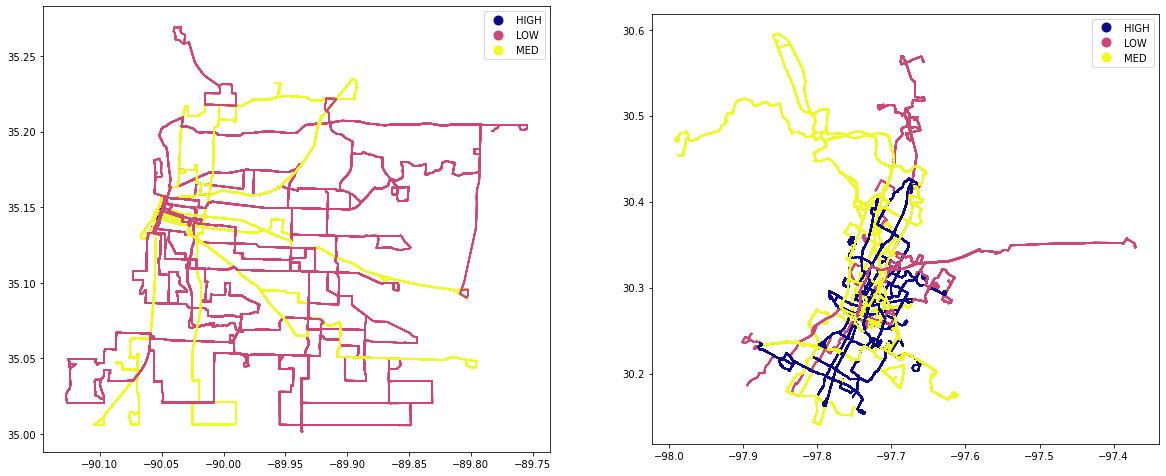

In [26]:
# Basic comparison between the two cities PT routes with their frequency level

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
ax1 = mata.plot(ax=ax1, column='freq_level', legend=True, cmap = 'plasma')
ax2 = capmetro.plot(ax=ax2, column='freq_level', legend=True, cmap = 'plasma')


## 3. Data analysis + Results

Add and explain your analysis workflow below here.

In [29]:
from rasterio.features import shapes

def raster_processing(path):
    ## Transfrom Raster into Shapefile 
    fp = os.path.join(path)
    # Open the file:
    raster = rasterio.open(fp)
    # Transform the raster into a shapefile
    # https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons/187883

    mask = None
    with rasterio.Env():
            image = raster.read() # first band
            results = ({'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(shapes(image, mask=mask, transform=raster.transform)))

    geoms = list(results)
    pop_grid  = gpd.GeoDataFrame.from_features(geoms)
    pop_grid = pop_grid.drop((pop_grid.index[pop_grid['raster_val'] <= 0]))
    
    # Rename for a more intuitive meaning
    pop_grid = pop_grid.rename(columns = {"raster_val":"pop_cnt"})
    # Define the CRS
    pop_grid = pop_grid.set_crs("EPSG:4326")
    
    return pop_grid
   
shelby_grid = raster_processing("data/100m_grid_mem.tif")
travis_grid = raster_processing("data/austin_tx_tif.tif")

<AxesSubplot:>

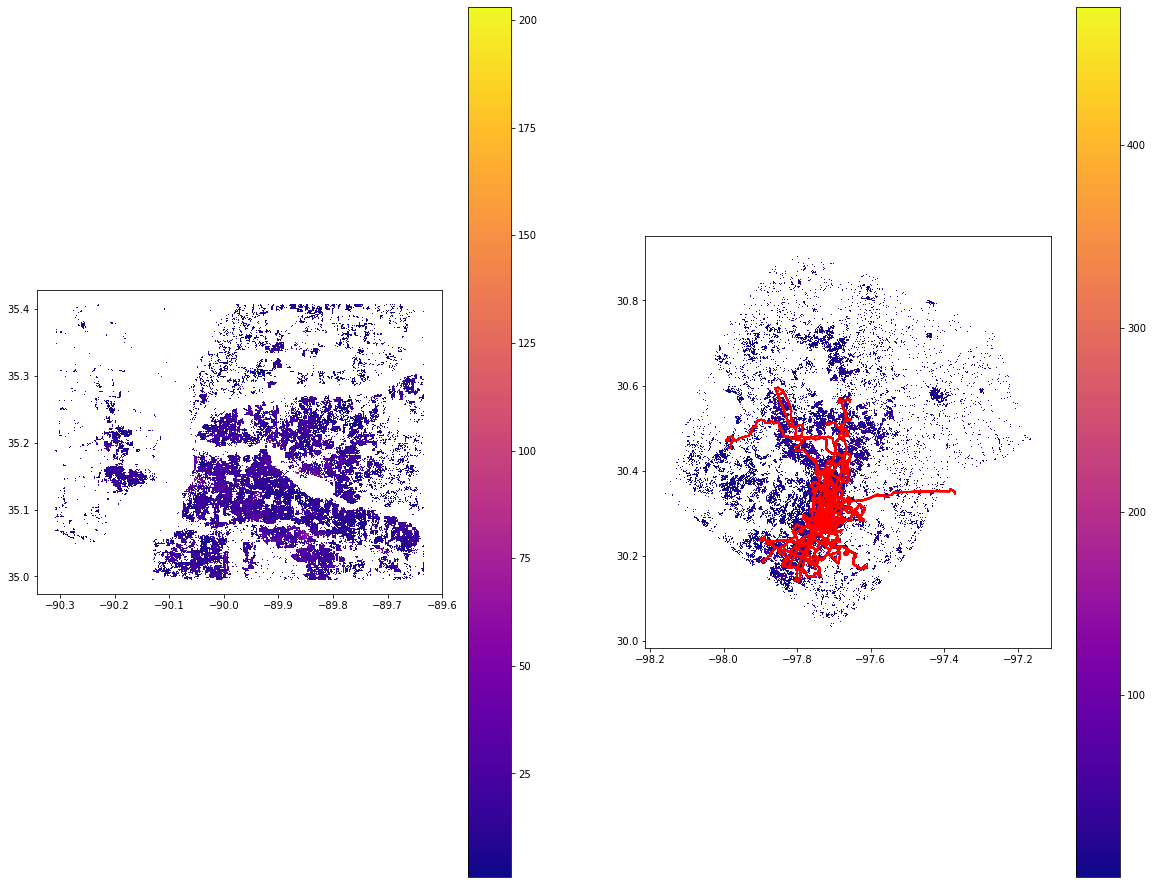

In [33]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
ax1 = shelby_grid.plot(ax=ax1, column='pop_cnt', legend=True, cmap = 'plasma')
ax2 = travis_grid.plot(ax=ax2, column='pop_cnt', legend=True, cmap = 'plasma')

In [26]:
from cenpy import products
import matplotlib.pyplot as plt
%matplotlib inline

dectest = products.Decennial2010()
mem_tn = dectest.from_county('Shelby, TN', 
                          level='block', 
                          variables=['P001001', 'P018001', 'P016001'])

/opt/conda/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [27]:
mem_tn

,GEOID,geometry,P001001,P016001,P018001,NAME,state,county,tract,block
0,471570224104024,"POLYGON ((-10032959.320 4163158.740, -10032927...",0.0,0.0,0.0,"Block 4024, Block Group 4, Census Tract 224.10...",47,157,022410,4024
1,471579803001010,"POLYGON ((-10036517.420 4173606.580, -10036503...",0.0,0.0,0.0,"Block 1010, Block Group 1, Census Tract 9803, ...",47,157,980300,1010
2,471579803001011,"POLYGON ((-10036256.270 4173528.650, -10036072...",0.0,0.0,0.0,"Block 1011, Block Group 1, Census Tract 9803, ...",47,157,980300,1011
3,471579803001031,"POLYGON ((-10035613.400 4173089.470, -10035603...",0.0,0.0,0.0,"Block 1031, Block Group 1, Census Tract 9803, ...",47,157,980300,1031
4,471579803001003,"POLYGON ((-10038162.950 4174506.090, -10038089...",0.0,0.0,0.0,"Block 1003, Block Group 1, Census Tract 9803, ...",47,157,980300,1003
...,...,...,...,...,...,...,...,...,...,...
17270,471570209001004,"POLYGON ((-9981752.130 4205691.060, -9981462.7...",0.0,0.0,0.0,"Block 1004, Block Group 1, Census Tract 209, S...",47,157,020900,1004
17271,471570208202001,"POLYGON ((-9979825.750 4200605.920, -9979766.8...",0.0,0.0,0.0,"Block 2001, Block Group 2, Census Tract 208.20...",47,157,020820,2001
17272,471570208101030,"POLYGON ((-9980548.540 4207393.860, -9980538.0...",0.0,0.0,0.0,"Block 1030, Block Group 1, Census Tract 208.10...",47,157,020810,1030
17273,471570208101017,"POLYGON ((-9984632.520 4212592.700, -9984619.8...",179.0,179.0,52.0,"Block 1017, Block Group 1, Census Tract 208.10...",47,157,020810,1017


In [89]:
mem_tn['P001001'].sum()

927644.0

In [28]:
mem_tn = mem_tn.to_crs(CRS("WGS84"))

<AxesSubplot:>

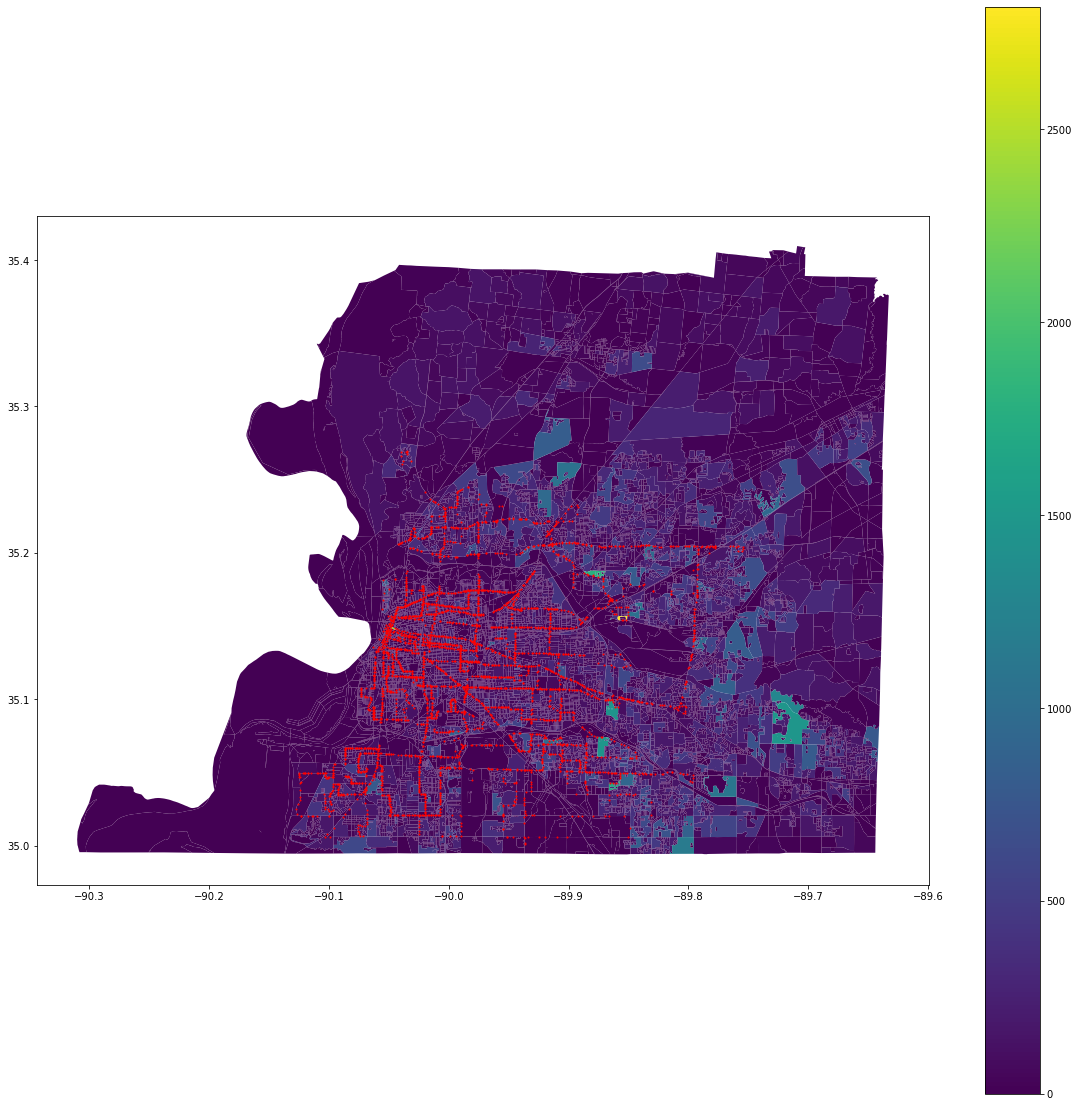

In [42]:
ax = mem_tn.plot('P001001', figsize = (20,20), legend = True)
stops.plot(ax = ax, color = 'red', markersize = 1)

In [97]:
# Create a spatial join between pop grid and stops
intersect = gpd.sjoin(pop_grid, stops, how="inner", op="intersects")
# check population count remaining in spatial join
intersect['pop_cnt'].sum()

In [31]:
def buffer_join(stops, grid):
    # create 500 meter buffers around bus stops
    # Reproject dataframe to one with meters instead of degrees
    stops = stops.to_crs(epsg=3395)
    buffer = stops.buffer(500, cap_style=1)
    # Transform Buffer GeoSeries into GeoDataFrame
    service_areas = gpd.GeoDataFrame(buffer)
    service_areas['geometry'] = service_areas[0]
    # Define the CRS in order to transform to WGS 84 
    service_areas = service_areas.set_crs(epsg=3395)
    service_areas = service_areas.to_crs("EPSG:4326")
    
    # Create a join between the buffered bus stops and the population grid
    join_s = gpd.sjoin(grid, service_areas, how="inner", op="intersects")
    # Remove duplicates of polygons in the df
    join_s = join_s[~join_s.index.duplicated(keep='first')]
    # Check the dataframe
    return join_s


pop_access_mem = buffer_join(stops_mem, shelby_grid)
pop_access_aust = buffer_join(stops_austin, travis_grid)

<AxesSubplot:>

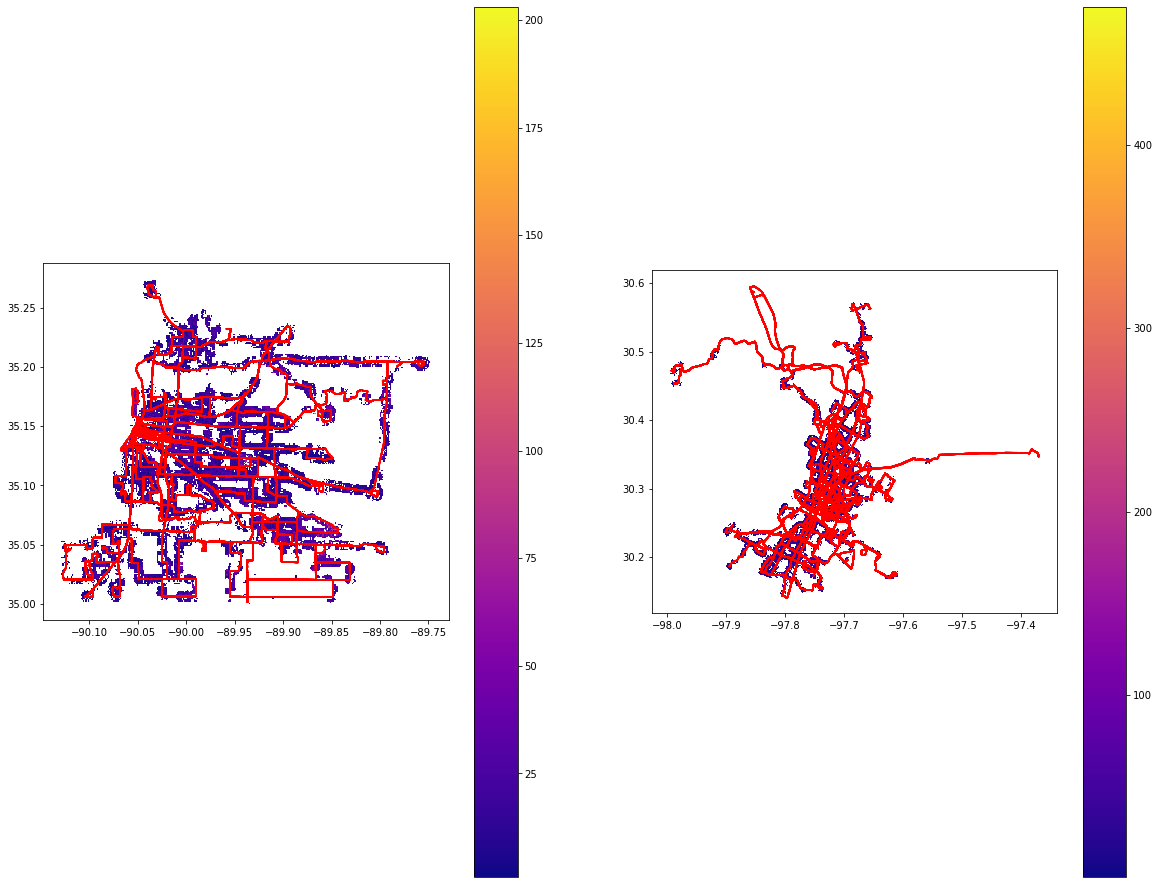

In [32]:
# Plot the data together
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
ax1 = pop_access_mem.plot(ax=ax1, column='pop_cnt', legend=True, cmap = 'plasma')
ax2 = pop_access_aust.plot(ax=ax2, column='pop_cnt', legend=True, cmap = 'plasma')
mata.plot(ax = ax1, color = 'red')
capmetro.plot(ax = ax2, color = 'red')

In [44]:
# We fetch data for Memphis from OSM
osm = OSM(get_data("memphis"))

# Parse roads that can be driven by car
nodes, edges = osm.get_network(network_type="walking", nodes=True)

In [45]:
edges.head()

,access,area,bicycle,bridge,cycleway,foot,footway,highway,junction,lanes,...,width,id,timestamp,version,tags,osm_type,geometry,u,v,length
0,None,None,None,None,None,None,None,residential,None,None,...,None,12772799,0,-1,"{""tiger:cfcc"":""A41"",""tiger:county"":""Crittenden...",way,"LINESTRING (-90.19383 35.21924, -90.19381 35.2...",116829005,116829007,34.146
1,None,None,None,None,None,None,None,residential,None,None,...,None,12772799,0,-1,"{""tiger:cfcc"":""A41"",""tiger:county"":""Crittenden...",way,"LINESTRING (-90.19381 35.21894, -90.19371 35.2...",116829007,116829008,34.537
2,None,None,None,None,None,None,None,residential,None,None,...,None,12772799,0,-1,"{""tiger:cfcc"":""A41"",""tiger:county"":""Crittenden...",way,"LINESTRING (-90.19371 35.21864, -90.19218 35.2...",116829008,116829012,277.929
3,None,None,None,None,None,None,None,residential,None,None,...,None,12772799,0,-1,"{""tiger:cfcc"":""A41"",""tiger:county"":""Crittenden...",way,"LINESTRING (-90.19218 35.21647, -90.19212 35.2...",116829012,7221804127,10.950
4,None,None,None,None,None,None,None,residential,None,None,...,None,12772799,0,-1,"{""tiger:cfcc"":""A41"",""tiger:county"":""Crittenden...",way,"LINESTRING (-90.19212 35.21639, -90.19198 35.2...",7221804127,7221804129,21.310


In [47]:
edges['length'].describe()

count    653871.000000
mean         27.428190
std          45.614806
min           0.011000
25%           5.979000
50%          13.268000
75%          29.922000
max        2207.651000
Name: length, dtype: float64

<AxesSubplot:>

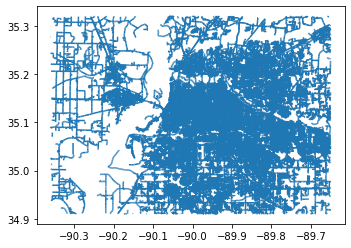

In [46]:
edges.plot()

In [23]:
# Creare the NetworkX graph

G = osm.to_graph(nodes, edges[["oneway", "length", "u", "v", "geometry"]], graph_type="networkx")

In [66]:
G

In [25]:
# Next we will iterate over the bus stop dataframe to 0.5km service areas according to the NetworkX graph

import osmnx as ox 
import networkx as nx

service_areas = gpd.GeoDataFrame()
for idx, row in stops.iterrows():
    # Find the closest nodes for origin
    orig_node_id = ox.get_nearest_node(G, point=(row['geometry'].y, row['geometry'].x), method='haversine')
    # Create the 0.5km catchment area around each bus stop (default is set in meters so 0.5km should be 500m)
    sub_graph = nx.ego_graph(G, n=orig_node_id, radius= 500, distance = 'length')
    #if len(sub_graph) == 1:
        #pass
    #else:
    # Extract the nodes and edges of the sub_graph/catchment area of each bus stop
    nodes, edges = ox.graph_to_gdfs(sub_graph)
    
     # Join bus stop catchment area nodes with the population data 
    join2 = gpd.sjoin(pop_grid, nodes, how="inner", op="intersects")
    # Remove duplicates of polygons in the df
    join2 = join2[~join2.index.duplicated(keep='first')]
        # Store the sum of total population for this catchment area
    pop_cnt = join2['pop_cnt'].sum()
        #Store a multipolygon of the census blocks for the catchment area
    geom = join2['geometry'].unary_union
        
        # Store the column names with the corresponding variables created above
    data = {'geometry': [geom], 'stop_name': [row['stop_name']], 'pop': [pop_cnt], 'stop_id': [row['stop_id']], 'stop_desc' : [row['stop_desc']], 
               'wheelchair_boarding': [row['wheelchair_boarding']]}
        # Add them to a dataframe
    service_area = gpd.GeoDataFrame(data)
        
    # Add each dataframe to the empty dataframe created before the for loop with each iteration
    service_areas = service_areas.append(service_area)

    
service_areas.head()

KeyboardInterrupt: 

In [75]:
service_areas

,geometry,stop_name,pop,stop_id,stop_desc,wheelchair_boarding
0,"POLYGON ((-89.90000 35.21667, -89.90833 35.216...",YALE@COVINGTON PIKE,1499.384644,6,YALE RD & CONNECTING RD,0
0,"POLYGON ((-89.98333 35.07500, -89.99167 35.075...",AIRWAYS BLVD@KETCHUM,1717.057129,7,AIRWAYS BLVD & KETCHUM RD,0
0,"POLYGON ((-90.01667 35.13333, -90.02500 35.133...",CLEVELAND@MADISON,5487.728271,10,N CLEVELAND ST & COURT AVE,0
0,"POLYGON ((-90.05000 35.12500, -90.05833 35.125...",4TH ST@ GEORGIA AVE,2431.838867,15,S 4TH ST & E GEORGIA AVE,0
0,"POLYGON ((-90.05833 35.12500, -90.06667 35.125...",CENTRAL STATION,2638.091919,24,S FRONT ST & E CALHOUN AVE,0
...,...,...,...,...,...,...
0,"POLYGON ((-90.09167 35.00833, -90.09167 35.000...",THIRD@WEAVER,614.150635,7096,0 S 3RD ST & DRIVEWAY,0
0,"POLYGON ((-90.08333 35.01667, -90.08333 35.008...",THIRD@DELTA,1483.279358,7097,0 S 3RD ST & DELTA RD,0
0,"POLYGON ((-90.09167 35.01667, -90.10000 35.016...",THIRD@SHELBY,2154.497620,7098,0 S 3RD ST & RAMP,0
0,"POLYGON ((-90.08333 35.01667, -90.09167 35.016...",THIRD@FORD,2692.416443,7099,0 S 3RD ST & WESTVIEW RD,0


In [76]:
service_areas.reset_index(inplace=True)

In [86]:
service_areas.to_file("data/memphis_serviceareas.shp")

<AxesSubplot:>

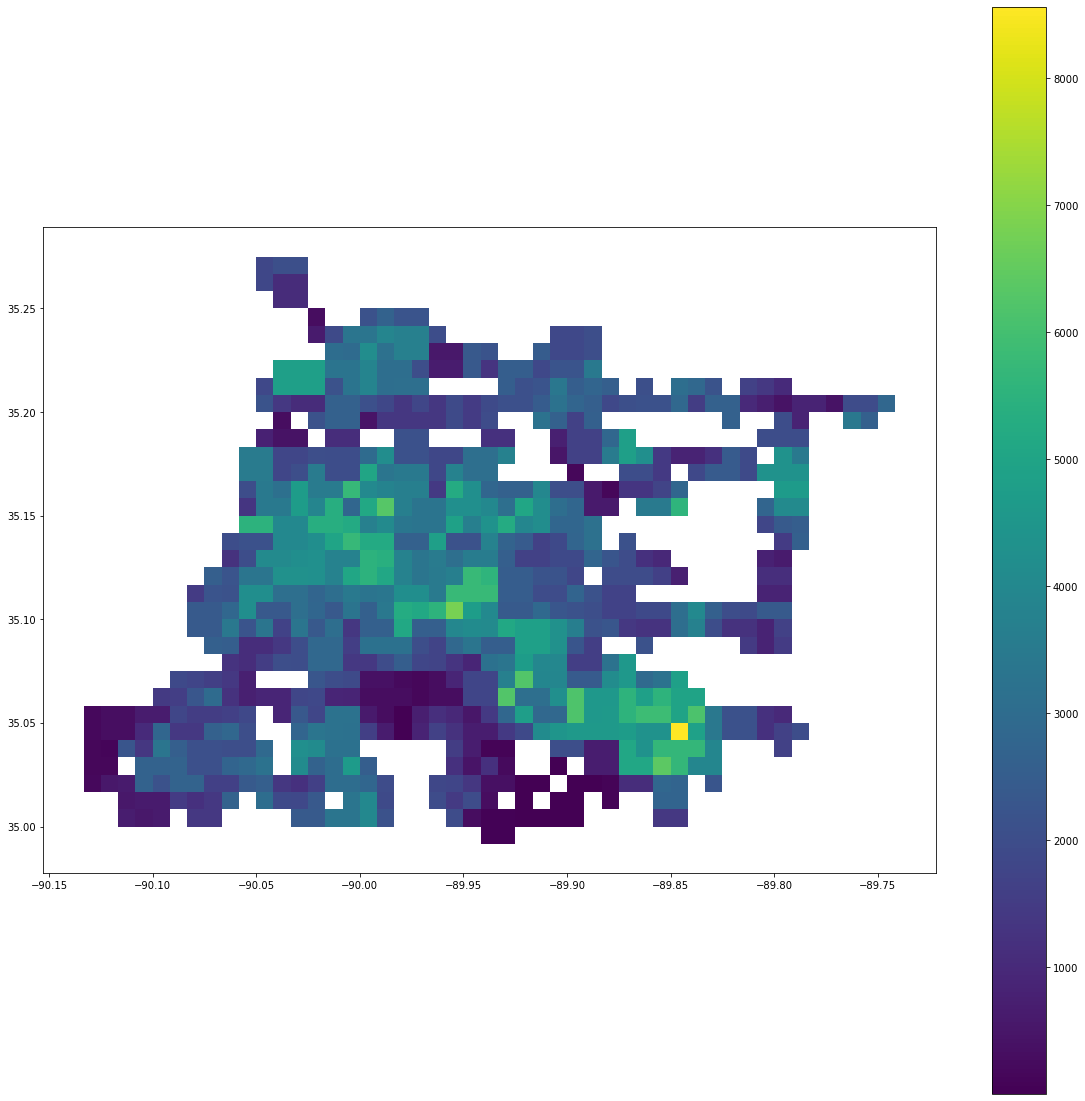

In [77]:
service_areas.plot('pop', figsize = (20, 20), legend = True)

In [78]:
service_areas['pop'].sum()

10034135.999365069

<AxesSubplot:>

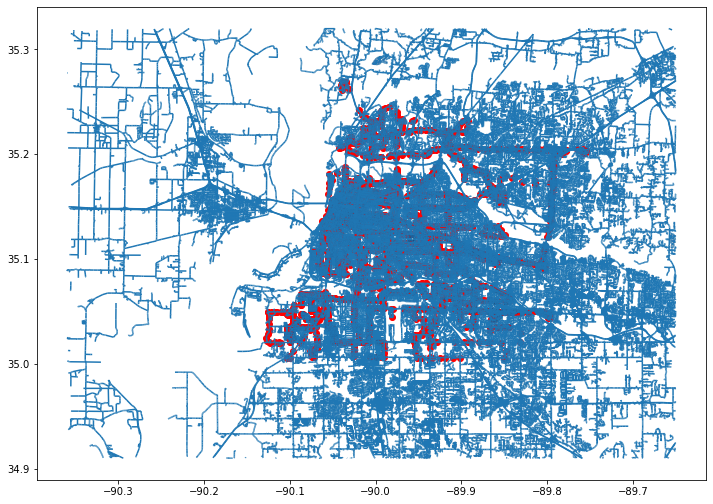

In [53]:
ax = edges.plot(figsize = (12,12))
stops.plot(ax = ax, color = 'red')

Create a 0.5 km buffer around each bus stops in order to assess percentage of population with access to the stop


In [ ]:
for idx, row in stops.iterrows():
    
    # Find the closest nodes for origin
    orig_node_id = ox.get_nearest_node(G, point=(row['geometry'].y, row['geometry'].x), method='haversine')
    # Create the 10 min (600 sec) catchment area around each hospital 
    sub_graph = nx.ego_graph(G, n=orig_node_id, radius=600, distance = 'travel_time_seconds')
    

In [2]:
## Austin crash fatality data

import requests 
r = requests.get('https://www.austintexas.gov/police/reports/advance_search.cfm')

In [3]:
print(r.url)

https://www.austintexas.gov/police/reports/advance_search.cfm


In [14]:
r.encoding

'UTF-8'

In [1]:
payload = {'startdate': '01%2F07%2F2020', 'numdays': ['6']}
r = requests.get('https://www.austintexas.gov/police/reports/advance_search.cfm')
print(r.url)

NameError: name 'requests' is not defined

## 4. Discussion

Add discussion here.

## 5. References

TN Department of Safety and Homeland Security
https://www.tn.gov/content/dam/tn/safety/documents/dailyfatalitybycounty2020.pdf
Austin TX Traffic Fatalities 
https://www.austintexas.gov/department/traffic-fatalities

### Data
Center for International Earth Science Information Network - CIESIN - Columbia University. 2017. U.S. Census Grids (Summary File 1), 2010. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H40Z716C. Accessed DAY MONTH YEA